## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "/users/aeg/Downloads/HUMAN_9606_idmapping.dat"
mouse_idmapping_dat="/users/aeg/Downloads/MOUSE_10090_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!cat $mouse_idmapping_dat >> $idmapping_dat
!wc -l $idmapping_dat

cat: /users/aeg/Downloads/MOUSE_10090_idmapping.dat: No such file or directory
 6050174 ./tmpmap.dat


In [3]:
import logging, sys

# Set up logging
logging.basicConfig(level=logging.getLevelName("INFO"), handlers=[logging.StreamHandler(sys.stdout)],
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [5]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

2020-12-13 21:38:22,212 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
download_single_file(s3_annotations, annotations_file)

In [8]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [9]:
data.pubmedId.nunique()

850

In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [11]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [12]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
10,575312,phosphorylation,"[{'uniprotid': 'P02686-1', 'alias': [['p02686-1'], ['Myelin basic protein'], ['MBP'], ['Myelin A1 protein'], ['Myelin membrane encephalitogenic protein'], ['Golli-MBP1'], ['HOG7']], 'alternative_uniprots': []}, {'uniprotid': 'Q8I629', 'alias': [['q8i629_plaf7'], ['PF3D7_1201600']], 'alternative_uniprot

In [13]:
data.shape

(3381, 7)

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


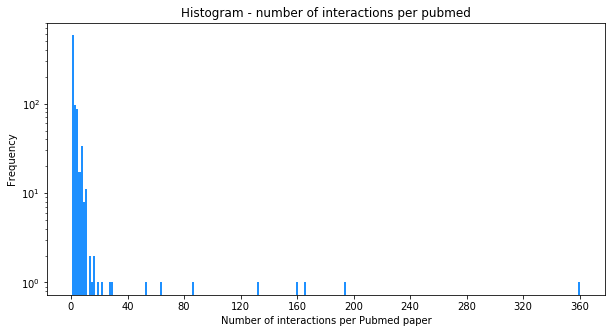

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

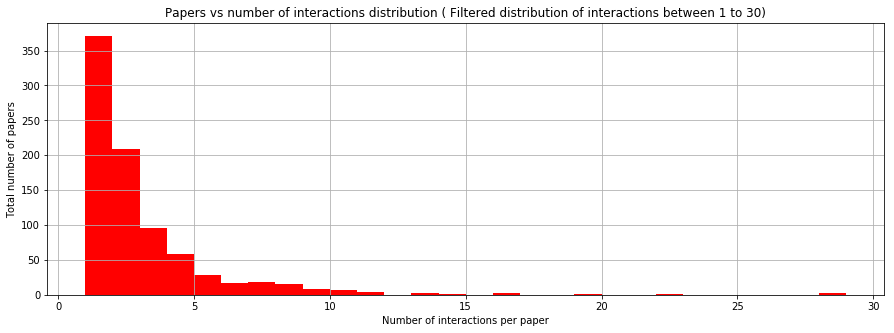

In [16]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

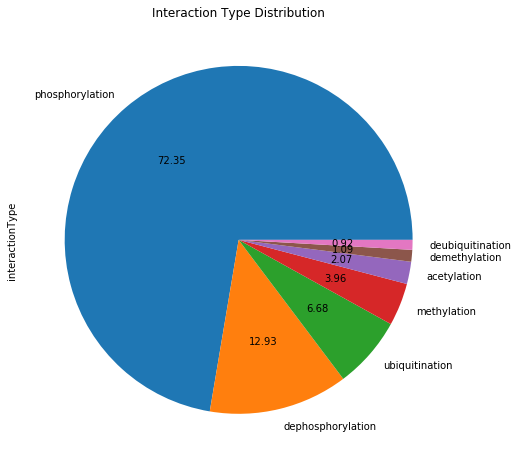

In [17]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [18]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

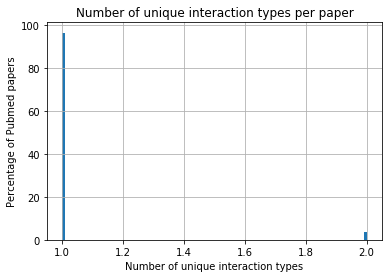

In [19]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

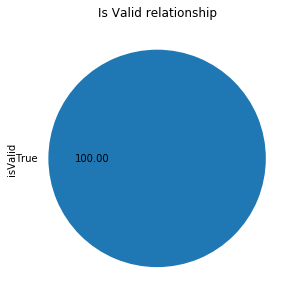

In [20]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

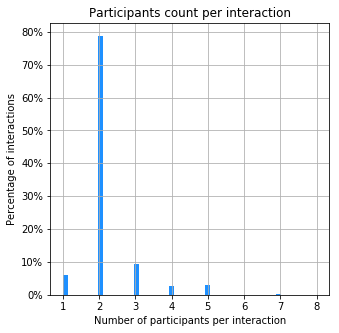

In [21]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [22]:
!pip install nltk==3.4.5

You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

0      phosphoryl
1     deubiquitin
2          methyl
3        demethyl
4          acetyl
5       ubiquitin
6    dephosphoryl
dtype: object


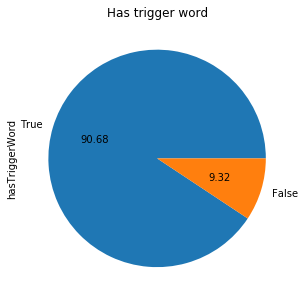

In [24]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [25]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [26]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 30 s, sys: 301 ms, total: 30.3 s
Wall time: 34.1 s


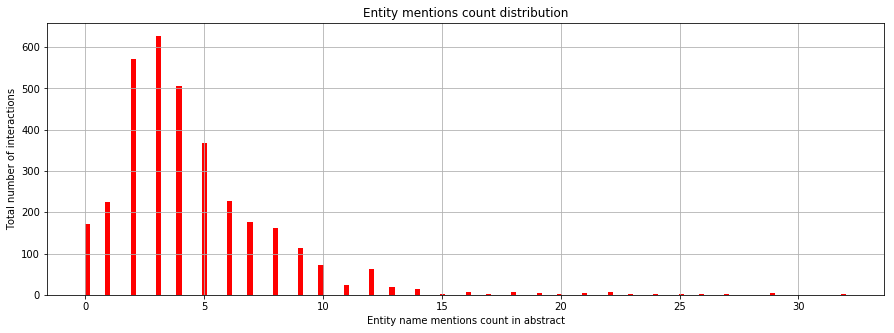

In [27]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

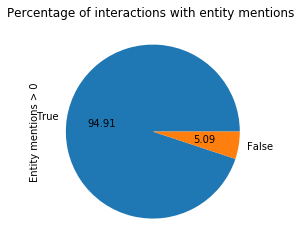

In [28]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [29]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
730,"[{'uniprotid': 'O43818', 'alias': [['u3ip2_human'], ['U3 small nucleolar RNA-interacting protein 2'], ['RRP9'], ['RNU3IP2'], ['U355K'], ['U3 small nucleolar ribonucleoprotein-associated 55 kDa protein'], ['RRP9 homolog']], 'alternative_uniprots': ['Q8IZ30', 'B2R996']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
820,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q9NR09', 'alias': [['birc6_human'], ['Baculoviral IAP repeat-containing protein 6'], ['RING-type E3 ubiquitin transferase BIRC6'], ['BIRC6'], ['KIAA1289'], ['Ubiquitin-conjugating BIR domain enzyme apollon'], ['BIR repeat-containing ubiquitin-conjugating enzyme']], 'alternative_uniprots': ['Q9ULD1']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
739,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'P06748-1', 'alias': [['p06748-1'], ['Nucleophosmin'], ['NPM1'], ['NPM'], ['Nucleolar phosphoprotein B23'], ['Nucleolar protein NO38'], ['Numatrin']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [30]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9


## Data Transformation

### Filter interactions with more than 2 participants

In [31]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

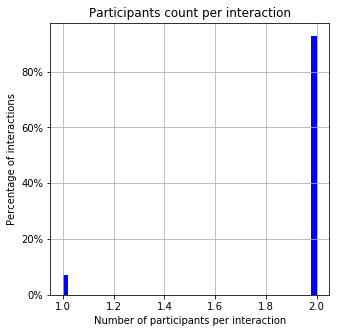

In [32]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


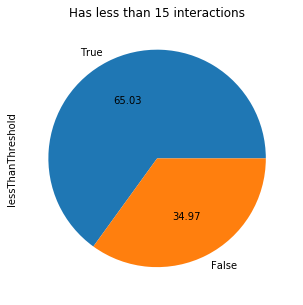

In [33]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [34]:
filtered = filtered.query("lessThanThreshold == 1")

In [35]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [36]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [37]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


In [38]:
data_transformed.shape

(1865, 14)

### Remove records where the alias is null

In [39]:
data_transformed.shape

(1865, 14)

In [40]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [41]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [42]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


### Normalise abstract

In [43]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        # 
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.text_gene_normaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [44]:
%%time

data_filtered = normalise_absract(data_filtered, annotations_file)

2020-12-13 21:40:08,048 - datatransformer.abstractGeneNormaliser - INFO - Starting transformation..
2020-12-13 21:40:12,625 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2020-12-13 21:40:12,626 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations ...
2020-12-13 21:40:12,755 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations_abstract...
2020-12-13 21:40:12,779 - datatransformer.abstractGeneNormaliser - INFO - Adding num_unique_gene_normalised_id...
2020-12-13 21:40:12,793 - datatransformer.abstractGeneNormaliser - INFO - Adding num_gene_normalised_id...
2020-12-13 21:40:12,806 - datatransformer.abstractGeneNormaliser - INFO - Completed transformation
CPU times: user 4.56 s, sys: 139 ms, total: 4.7 s
Wall time: 4.85 s


In [45]:
data_filtered.shape

(1766, 19)

In [46]:
data_filtered.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.","O43293-2 (O43293-2) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293-2 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293-2 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to Q10728(Q10728) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293-2 to Q10728 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to Q10728, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation.","[{'start': '0', 'end': '33', 'name': 'Zipper-interacting protein kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '35', 'end': '45', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '197', 'end': '207', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '240', 'end': '246', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '285', 'end': '295', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '416', 'end': '454', 'name': 'myosin phosphatase targeting subunit 1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '455', 'end': '460', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '563', 'end': '569', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '651', 'end': '661', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '665', 'end': '670', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '

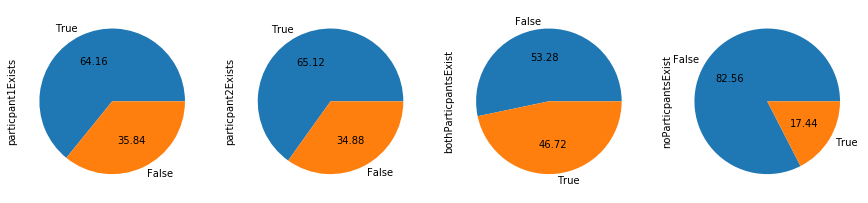

In [47]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


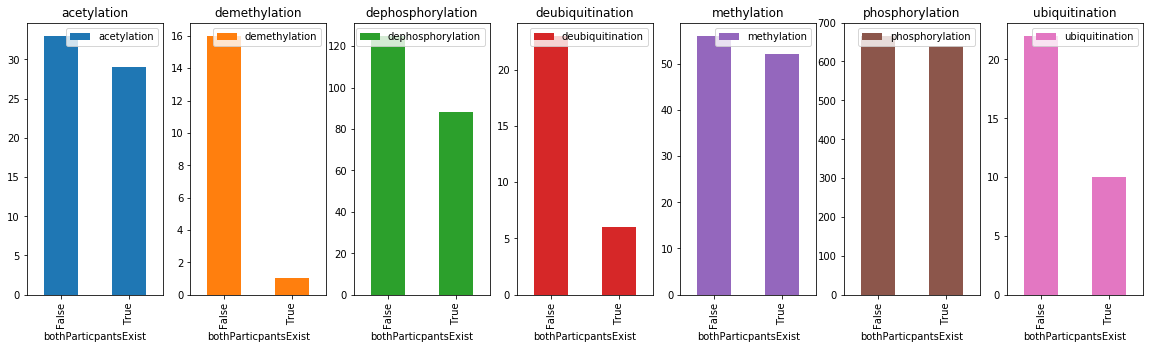

In [48]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [49]:
data_filtered.query("particpant2Exists == False").sample(4)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
409,2,True,2370516,phosphorylation,True,True,"[[gys1_human], [Glycogen [starch] synthase, muscle], [GYS1], [GYS]]",P13807,"[[gsk3b_human], [Glycogen synthase kinase-3 beta], [GSK3B], [Serine/threonine-protein kinase GSK3B]]",P49841,2,10481074,None,"The Axin-dependent phosphorylation of beta-catenin catalysed by glycogen synthase kinase-3 (GSK3) is inhibited during embryogenesis. This protects beta-catenin against ubiquitin-dependent proteolysis, leading to its accumulation in the nucleus, where it controls the expression of genes important for development. Frequently rearranged in advanced T-cell lymphomas 1 (FRAT1) is a mammalian homologue of a GSK3-binding protein (GBP), which appears to play a key role in the correct establishment of the dorsal-ventral axis in Xenopus laevis. Here, we demonstrate that FRATtide (a peptide corresponding to residues 188-226 of FRAT1) binds to GSK3 and prevents GSK3 from interacting with Axin. FRATtide also blocks the GSK3-catalysed phosphorylation of Axin and beta-catenin, suggesting a potential mechanism by which GBP could trigger axis formation. In contrast, FRATtide does not suppress GSK3 activity towards other substrates, such as glycogen synthase and eIF2B, whose phosphorylation is independent of Axin but dependent on a 'priming' phosphorylation. This may explain how the essential cellular functions of GSK3 can continue, despite the suppression of beta-catenin phosphorylation.","The O15169-dependent phosphorylation of P35222 catalysed by glycogen synthase kinase-3 (GSK3) is inhibited during embryogenesis. This protects P35222 against ubiquitin-dependent proteolysis, leading to its accumulation in the nucleus, where it controls the expression of genes important for development. Q92837 (Q92837) is a mammalian homologue of a O75925 (O75925), which appears to play a key role in the correct establishment of the dorsal-ventral axis in Xenopus laevis. Here, we demonstrate that FRATtide (a peptide corresponding to residues 188-226 of Q92837) binds to GSK3 and prevents GSK3 from interacting with O15169. FRATtide also blocks the GSK3-catalysed phosphorylation of O15169 and P35222, suggesting a potential mechanism by which O75925 could trigger axis formation. In contrast, FRATtide does not suppress GSK3 activity towards other substrates, such as glycogen synthase and Q9UI10, whose phosphorylation is independent of O15169 but dependent on a 'priming' phosphorylation. This may explain how the essential cellular functions of GSK3 can continue, despite the suppression of P35222 phosphorylation.","[{'start': '4', 'end': '8', 'name': 'Axin', 'type': 'Gene', 'normalised_id': '8312'}, {'start': '38', 'end': '50', 'name': 'beta-catenin', 'type': 'Gene', 'normalised_id': '1499'}, {'start': '147', 'end': '159', 'name': 'beta-catenin', 'type': 'Gene', 'normalised_id': '1499'}, {'start': '314', 'end': '366', 'name': 'Frequently rearranged in advanced T-cell lymphomas 1', 'type': 'Gene', 'normalised_id': '10023'}, {'start': '368', 'end': '373', 'name': 'FRAT1', 'type': 'Gene', 'normalised_id': '10023'}, {'start': '380', 'end': '389', 'name': 'mammalian', 'type': 'Species', 'normalised_id': '9606'}, {'start': '405', 'end': '425', 'name': 'GSK3-binding protein', 'type': 'Gene', 'normalised_id': '8554'}, {'start': '427', 'end': '430', 'name': 'GBP', 'type': 'Gene', 'normalised_id': '8554'}, {'start': '525', 'end': '539', 'name': 'Xenopus laevis', 'type': 'Species', 'normalised_id': '8355'}, {'start': '624', 'end': '629', 'name': 'FRAT1', 'type': 'Gene', 'normalised_id': '10023'}, {'start': '685', 'end': '689', 'name': 'Axin', 't

### Remove abstracts where both participants do not exists

In [50]:
data_filtered =  data_filtered.query('particpant2Exists == True')
data_filtered.shape

(1150, 23)

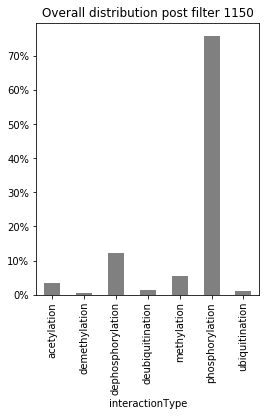

In [51]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

#### Check how many contain the trigger word

In [52]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,False,True
interactionType,,
acetylation,4,36
demethylation,0,6
dephosphorylation,28,111
deubiquitination,2,13
methylation,0,64
phosphorylation,79,794
ubiquitination,0,13


In [53]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,10.0,90.0
demethylation,0.0,100.0
dephosphorylation,20.1,79.9
deubiquitination,13.3,86.7
methylation,0.0,100.0
phosphorylation,9.0,91.0
ubiquitination,0.0,100.0


### Split Train/Test/validation

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [55]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array(['23219879', '17320160', '17805299', '17567753'], dtype=object)

In [56]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15678106', '15710384', '14603323',
       '12878161', '12230472', '11588219', '11894096', '11882901',
       '19656744', '16601676', '11027293'], dtype=object)

In [57]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [58]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15710384', '12878161', '12230472',
       '11588219', '19656744', '16601676', '11027293'], dtype=object)

In [59]:
val.query("interactionType == 'ubiquitination'")


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1181,8,True,7618,ubiquitination,True,True,"[[rnf12_human], [E3 ubiquitin-protein ligase RLIM], [RING-type E3 ubiquitin transferase RLIM], [RLIM], [RNF12], [RING finger protein 12], [LIM domain-interacting RING finger protein], [RING finger LIM domain-binding protein], [Renal carcinoma antigen NY-REN-43]]",Q9NVW2,"[[ldb1_human], [LIM domain-binding protein 1], [Nuclear LIM interactor], [Carboxyl-terminal LIM domain-binding protein 2], [LIM domain-binding factor CLIM2], [LDB1], [CLIM2]]",Q86U70,2,11882901,None,"The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with RLIM (RING finger LIM domain-binding protein) and with CLIM (cofactor of LIM-HD proteins; also known as NLI, Ldb and Chip) cofactors. The co-repressor RLIM inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify RLIM as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of RLIM with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.","The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with Q9NVW2 (Q9NVW2) and with CLIM (cofactor of LIM-HD proteins; also known as Q86U70, Ldb and Chip) cofactors. The co-repressor Q9NVW2 inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify Q9NVW2 as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of Q9NVW2 with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.","[{'start': '503', 'end': '507', 'name': 'RLIM', 'type': 'Gene', 'normalised_id': '51132'}, {'start': '509', 'end': '547', 'name': 'RING finger LIM domain-binding protein', 'type': 'Gene', 'normalised_id': '51132'}, {'start': '607', 'end': '610', 'name': 'NLI', 'type': 'Gene', 'normalised_id': '8861'}, {'start': '654', 'end': '658', 'name': 'RLIM', 'type': 'Gene', 'normalised_id': '51132'}, {'start': '870', 'end': '874', 'name': 'RLIM', 'type': 'Gene', 'normalised_id': '51132'}, {'start': '1065', 'end': '1069', '

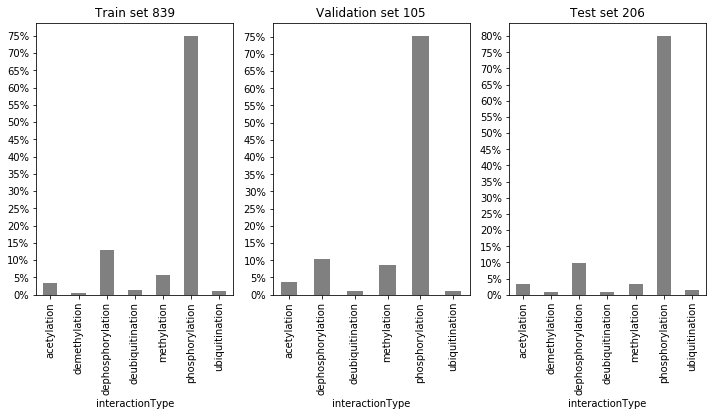

In [60]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

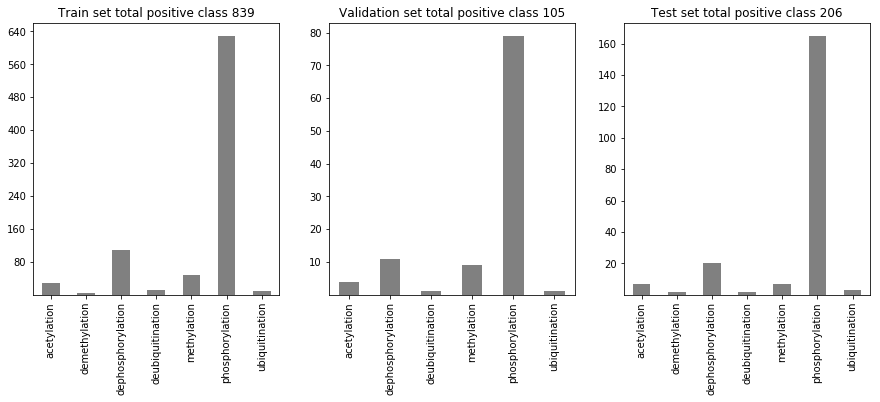

In [61]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

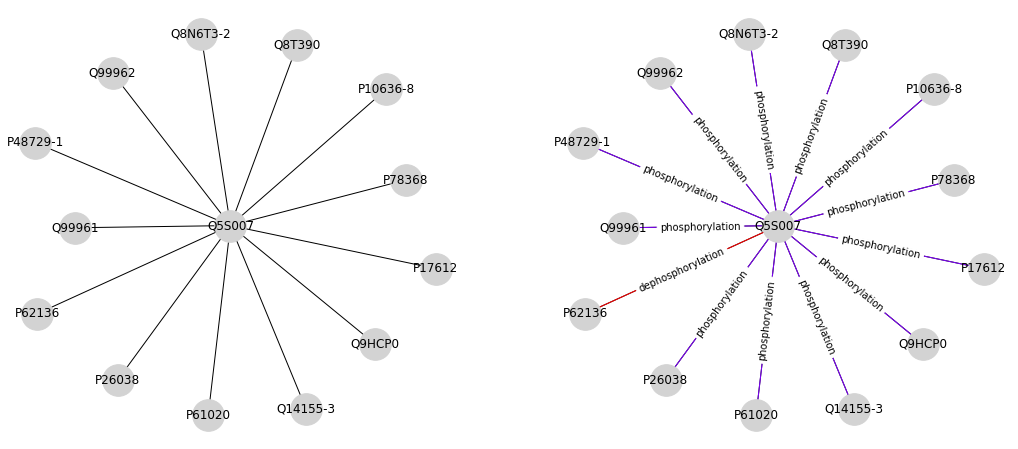

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(a=78, version=2)

fig,ax=plt.subplots(1,2, figsize=(18,8))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])


edge_label = nx.get_edge_attributes(G,'type')

colors = {i:random.randint(0, 50) for i in train['interactionType'].unique()}
edge_colors = [ colors[l]  for _,l in edge_label.items()]

cmap=plt.cm.get_cmap("rainbow")
vmin = min(edge_colors)
vmax = max(edge_colors)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edges(G, pos,  width=1.0, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_edge_labels(G, pos=pos,alpha=1, edge_labels = nx.get_edge_attributes(G,'type'), ax=ax[1])

plt.savefig('network.pdf', bbox_inches="tight")



plt.show()

### Generate negative samples

In [63]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [64]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [65]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [66]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [67]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [68]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



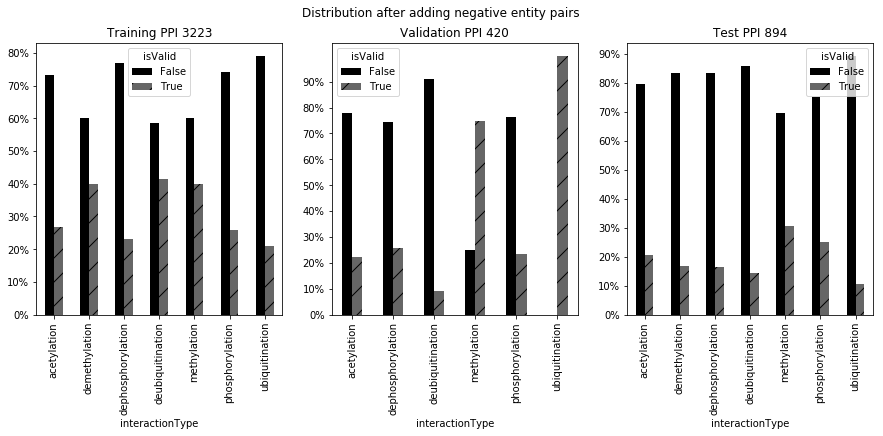

In [69]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

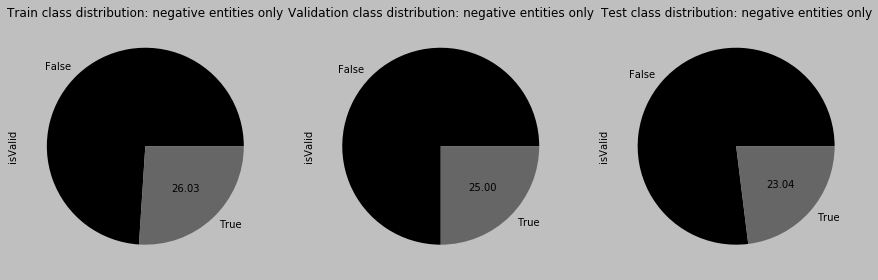

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [71]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [72]:
!aws s3 cp  $train_file $s3_results_prefix
!aws s3 cp  $test_file $s3_results_prefix
!aws s3 cp  $val_file $s3_results_prefix



upload: ./train_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/train_unique_negative_entity_only.json
upload: ./test_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json
upload: ./val_unique_negative_entity_only.json to s3://aegovan-data/processed_dataset/val_unique_negative_entity_only.json


In [73]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,79,29
demethylation,6,4
dephosphorylation,362,108
deubiquitination,17,12
methylation,72,48
phosphorylation,1814,629
ubiquitination,34,9


In [74]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


In [75]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [76]:
feature_cols = ["pubmedId","pubmedabstract","annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id", "normalised_abstract", "participant1Id", "participant2Id"]

derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [77]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [78]:
feature_cols = ["pubmedId","pubmedabstract", "annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id","normalised_abstract", "participant1Id", "participant2Id", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [79]:
train_multiclass["class"].value_counts()

other                2384
phosphorylation       629
dephosphorylation     108
methylation            48
acetylation            29
deubiquitination       12
ubiquitination          9
demethylation           4
Name: class, dtype: int64

In [80]:
test_multiclass["class"].value_counts()

other                688
phosphorylation      165
dephosphorylation     20
methylation            7
acetylation            7
ubiquitination         3
demethylation          2
deubiquitination       2
Name: class, dtype: int64

In [81]:
val_multiclass["class"].value_counts()

other                315
phosphorylation       79
dephosphorylation     11
methylation            9
acetylation            4
ubiquitination         1
deubiquitination       1
Name: class, dtype: int64

In [82]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [97]:
test_multiclass.head(n=1)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,class
0,16407301,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","[{'start': '0', 'end': '24', 'name': 'MAPK/ERK kinase kinase 3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '26', 'end': '31', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '215', 'end': '220', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '543', 'end': '548', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '625', 'end': '628', 'name': 'p38', 'type': 'Gene', 'normalised_id': '1432'}, {'start': '732', 'end': '737', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '853', 'end': '856', 'name': 'MEK', 'type': 'Gene', 'normalised_id': '5609'}, {'start': '920', 'end': '925', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1058', 'end': '1063', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1155', 'end': '1160', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1280', 'end': '1285', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1402', 'end': '1406', 'name': 'MKK6', 'type': 'Gene', 'normalised_id': '5608'}, {'start': '1592', 'end': '1597', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1698', 'end': '1703', 'name': 'MEKK3', 'type': 'Gene', 'normalised_id': '4215'}, {'start': '1774', 'end': '1778', 'name': 'PP2A', 'type': 'Gene', 'normalised_id': '5524'}]",5,15,"Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement f

In [83]:
!aws s3 cp  $val_multi_file $s3_results_prefix
!aws s3 cp  $test_multi_file $s3_results_prefix
!aws s3 cp  $train_multi_file $s3_results_prefix

upload: ./val_multiclass.json to s3://aegovan-data/processed_dataset/val_multiclass.json
upload: ./test_multiclass.json to s3://aegovan-data/processed_dataset/test_multiclass.json
upload: ./train_multiclass.json to s3://aegovan-data/processed_dataset/train_multiclass.json


In [84]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")

#### Step 2: Add negative interaction types

In [85]:

# train = generate_negative_interaction(train)
# test = generate_negative_interaction(test)
# val = generate_negative_interaction(val)


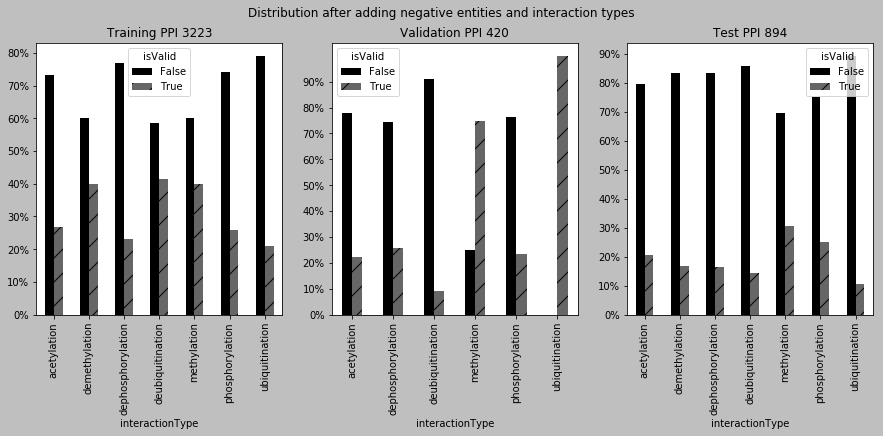

In [86]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.png",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

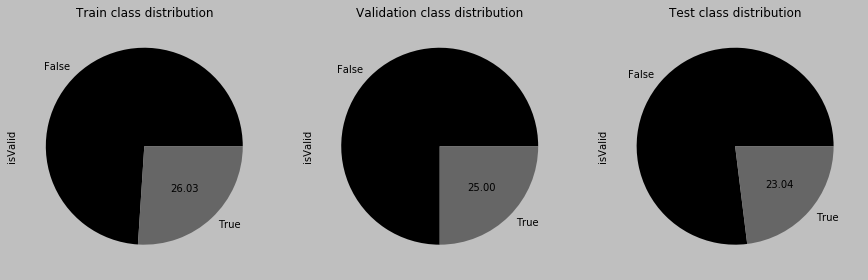

In [87]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [88]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,79,29
demethylation,6,4
dephosphorylation,362,108
deubiquitination,17,12
methylation,72,48
phosphorylation,1814,629
ubiquitination,34,9


In [89]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [90]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


In [91]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [92]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,256.0,79.0
ubiquitination,NaN,1.0


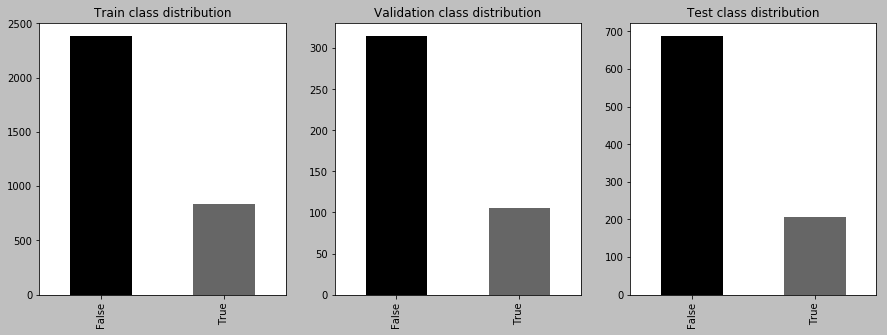

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.bar( ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.bar( ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.bar( ax=ax[2])



plt.savefig("Interaction.png")

In [94]:
train.to_json("train_unique_pub_v6_max_neg.json")
test.to_json("test_unique_pub_v6_max_neg.json")
val.to_json("val_unique_pub_v6_max_neg.json")

In [95]:
train.sample(n=20).to_json("sample_train.json")

In [96]:
train.query('isValid == True').sample(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
2597,6,True,1297422,phosphorylation,True,True,"[[lck_human], [Tyrosine-protein kinase Lck], [LCK], [Lymphocyte cell-specific protein-tyrosine kinase], [p56-LCK], [Leukocyte C-terminal Src kinase], [Protein YT16], [Proto-oncogene Lck], [T cell-specific protein-tyrosine kinase]]",P06239,"[[ptn6_human], [Tyrosine-protein phosphatase non-receptor type 6], [PTPN6], [HCP], [Protein-tyrosine phosphatase 1C], [Hematopoietic cell protein-tyrosine phosphatase], [SH-PTP1], [Protein-tyrosine phosphatase SHP-1], [PTP1C]]",P29350,2,8114715,None,"The phosphorylation and dephosphorylation of proteins on tyrosyl residues are key regulatory mechanisms in T-cell signal transduction and are controlled by the opposing activities of protein tyrosine kinases and phosphotyrosyl phosphatases (PTPs). In T cells, several nontransmembrane protein tyrosine kinases are associated with receptors; for example, Lck is bound to the coreceptors CD4 and CD8 and becomes activated upon their stimulation. In comparison, little is known about the role of nontransmembrane PTPs in early T-cell signaling. SH-PTP1 (PTP1C, HCP, SHP) is a nontransmembrane PTP expressed primarily in hematopoietic cells, including T cells. We have found that SH-PTP1 is basally phosphorylated on serine in resting T cells. Upon stimulation of CD4 or CD8 either in a T-cell hybridoma cell line or in primary thymocytes, SH-PTP1 becomes tyrosyl phosphorylated. Moreover, SH-PTP1 is constitutively phosphorylated on tyrosine in the Lck-overexpressing lymphoma cell line LSTRA. SH-PTP1 is also a good substrate for recombinant Lck in vitro. Comparisons of the tryptic phosphopeptide maps of wild-type SH-PTP1 and deletion and point mutations establish that the two sites (Y-536 and Y-564) which are directly phosphorylated by Lck in vitro are also phosphorylated in vivo in LSTRA cells. One of these sites (Y-564) is phosphorylated in T cells in response to Lck activation. We conclude that SH-PTP1 undergoes Lck-dependent tyrosyl phosphorylation in T cells and likely plays a role in early T-cell signaling.","The phosphorylation and dephosphorylation of proteins on tyrosyl residues are key regulatory mechanisms in T-cell signal transduction and are controlled by the opposing activities of protein tyrosine kinases and phosphotyrosyl phosphatases (PTPs). In T cells, several nontransmembrane protein tyrosine kinases are associated with receptors; for example, P06239 is bound to the coreceptors P01730 and P01732 and becomes activated upon their stimulation. In comparison, little is known about the role of nontransmembrane PTPs in early T-cell signaling. P29350 (P29350, HCP, Q15466) is a nontransmembrane PTP expressed primarily in hematopoietic cells, including T cells. We have found that P29350 is basally phosphorylated on serine in resting T cells. Upon stimulation of P01730 or P01732 either in a T-cell hybridoma cell line or in primary thymocytes, P29350 becomes tyrosyl phosphorylated. Moreover, P29350 is constitutively phosphorylated on tyrosine in the P06239-overexpressing lymphoma cell line LSTRA. P29350 is also a good substrate for recombinant P06239 in vitro. Comparisons of the tryptic phosphopeptide maps of wild-type P29350 and deletion and point mutations establish that the two sites (Y-536 and Y-564) which are directly phosphorylated by P06239 in vitro are also phosphorylated in vivo in LSTRA cells. One of these sites (Y-564) is phosphorylated in T cells in response to P06239 activation. We conclude that P29350 undergoes P06239-dependent tyrosyl phosphorylation in T cells and likely plays a role in early T-cell signa